<a href="https://colab.research.google.com/github/Misobread/git_tutorial/blob/master/numpyro_diabates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
import os

import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.infer.util import initialize_model

import arviz as az

az.style.use("arviz-darkgrid")

In [126]:
from sklearn.datasets import fetch_california_housing
from sklearn import datasets

# california_housing = fetch_california_housing()
# train_x = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
# train_y = pd.Series(california_housing.target)

diabetes = datasets.load_diabetes()

train_x = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
train_y = pd.Series(diabetes.target)

train_x.head()
train_y.head()

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
dtype: float64

In [127]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(train_x)

# train_x_std = pd.DataFrame(scaler.transform(train_x), columns=train_x.columns)

(array([38., 80., 68., 62., 50., 41., 38., 42., 17.,  6.]),
 array([ 25. ,  57.1,  89.2, 121.3, 153.4, 185.5, 217.6, 249.7, 281.8,
        313.9, 346. ]),
 <BarContainer object of 10 artists>)

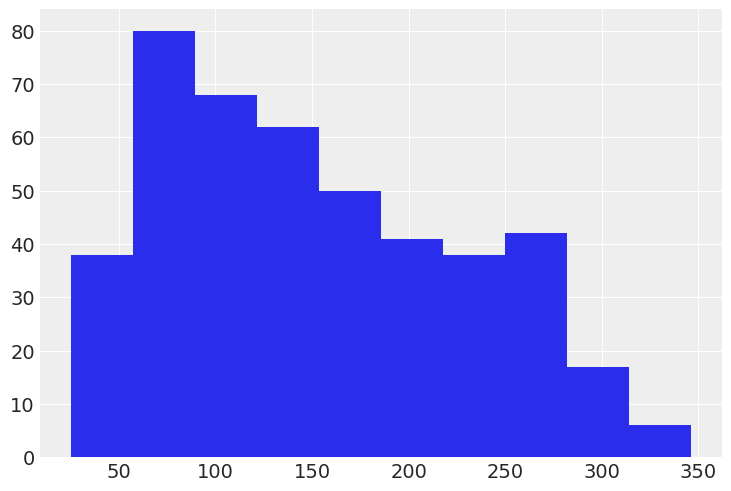

In [128]:
plt.hist(train_y)

(array([ 2.,  7., 24., 43., 55., 53., 68., 74., 72., 44.]),
 array([3.21887582, 3.48163212, 3.74438841, 4.00714471, 4.269901  ,
        4.5326573 , 4.79541359, 5.05816989, 5.32092619, 5.58368248,
        5.84643878]),
 <BarContainer object of 10 artists>)

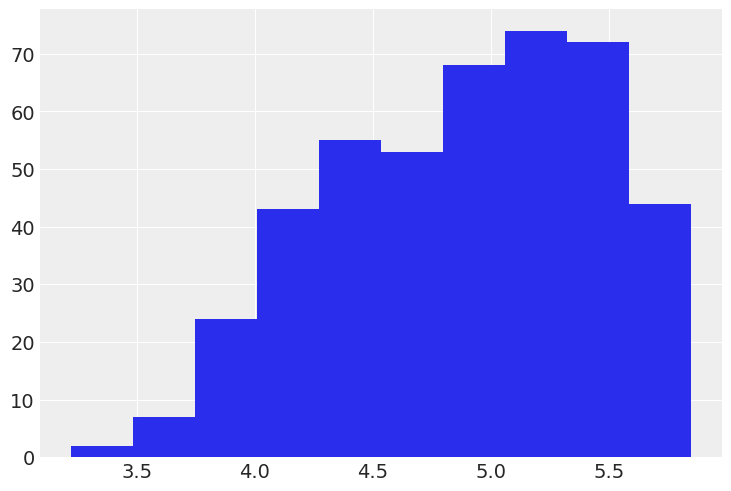

In [129]:
# 正規分布に近づけるため対数変換
plt.hist(np.log(train_y))

In [130]:
# train_y = np.log(train_y)

In [131]:
train_x.std()

age    0.047619
sex    0.047619
bmi    0.047619
bp     0.047619
s1     0.047619
s2     0.047619
s3     0.047619
s4     0.047619
s5     0.047619
s6     0.047619
dtype: float64

In [132]:
train_x.mean()

age   -1.444295e-18
sex    2.543215e-18
bmi   -2.255925e-16
bp    -4.854086e-17
s1    -1.428596e-17
s2     3.898811e-17
s3    -6.028360e-18
s4    -1.788100e-17
s5     9.243486e-17
s6     1.351770e-17
dtype: float64

In [133]:
train_x.shape

(442, 10)

In [134]:
# モデルの定義
def model(X, y=None):
    # 切片
    intercept = numpyro.sample("intercept", dist.Normal(0., 100.))

    # 重み
    coef = numpyro.sample("coef", dist.Normal(0.0, 100).expand([X.shape[1]]))

    # muを計算
    mu = numpyro.deterministic("mu", jnp.dot(X, coef) + intercept)

    with numpyro.plate("N", len(X)):
      numpyro.sample("obs", dist.Normal(mu), obs=y)

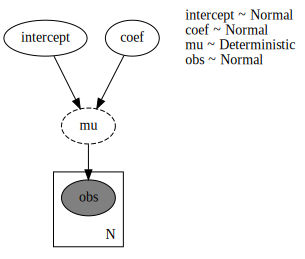

In [135]:
numpyro.render_model(
    model=model,
    model_kwargs={"X": train_x.values, "y": train_y.values},
    render_params=True,
    render_distributions=True
)

In [113]:
# 乱数の固定に必要
rng_key = random.PRNGKey(0)

# NUTSでMCMCを実行する
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(
    rng_key=rng_key,
    X=train_x.values,
    y=train_y.values
)
mcmc.print_summary()

<ipython-input-113-27dca435486e>:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|██████████| 3000/3000 [00:02<00:00, 1067.84it/s, 31 steps of size 1.08e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    coef[0]     -9.97      1.09     -9.97    -11.76     -8.20   7813.71      1.00
    coef[1]   -239.75      1.12   -239.73   -241.58   -237.92   6794.61      1.00
    coef[2]    519.89      1.23    519.90    518.05    522.10   7554.53      1.00
    coef[3]    324.35      1.21    324.35    322.35    326.34   7738.33      1.00
    coef[4]   -783.37      7.79   -783.41   -795.34   -769.71   2266.76      1.00
    coef[5]    469.76      6.31    469.82    459.52    480.31   2477.30      1.00
    coef[6]     97.15      3.96     97.09     90.71    103.57   2481.41      1.00
    coef[7]    176.01      2.93    176.03    170.91    180.57   5189.32      1.00
    coef[8]    747.92      3.23    747.96    742.43    752.97   2626.33      1.00
    coef[9]     67.71      1.21     67.72     65.67     69.62   7897.19      1.00
  intercept    152.13      0.05    152.13    152.06    152.21   8278.32      1.00

Number of dive

In [114]:
samples = mcmc.get_samples()

print(samples.keys())
print(samples["coef"].shape)

dict_keys(['coef', 'intercept', 'mu'])
(8000, 10)


In [137]:
for var_info in az.rhat(mcmc).values():
  print(var_info.name, var_info.values.mean().round(3), sep=' ')

coef 1.001
intercept 1.0
mu 1.0


array([[<Axes: title={'center': 'coef'}>,
        <Axes: title={'center': 'coef'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

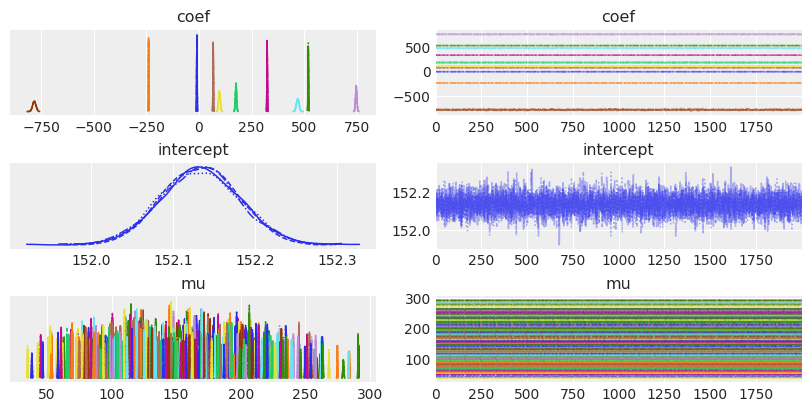

In [136]:
numpyro2az = az.from_numpyro(mcmc)
az.plot_trace(numpyro2az, figsize=(8,4))

In [117]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples)
predictions = predictive(rng_key_, X=train_x.values)["obs"]
print(predictions.shape)

posterior_mu = predictions

mean_mu = posterior_mu.mean(axis=0)
print(mean_mu.shape)

hpdi_mu = hpdi(posterior_mu, 0.95)
print(hpdi_mu.shape)

(8000, 442)
(442,)
(2, 442)


In [118]:
train_x.shape

(442, 10)

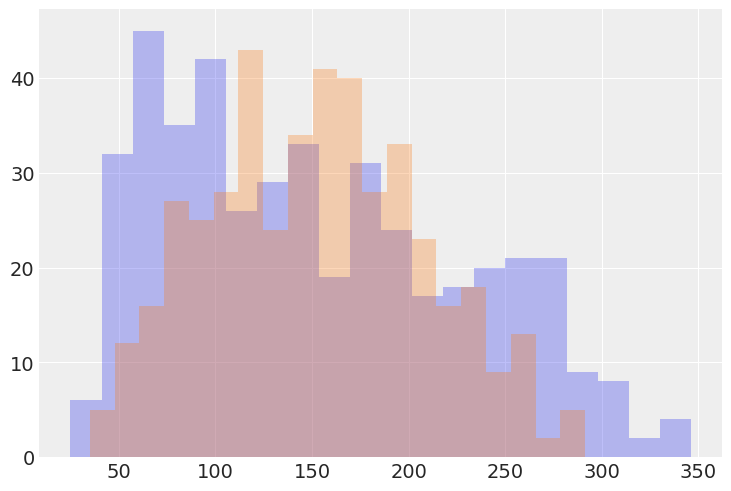

In [119]:
plt.hist(train_y, bins=20, alpha=0.3)
plt.hist(mean_mu, bins=20, alpha=0.3)
plt.show()

In [120]:
# def plot_regression(x, y_act, y_mean, y_hpdi):
#     # Sort values for plotting by x axis
#     idx = jnp.argsort(x)
#     x_sorted = x
#     y_sorted = y_act
#     y_mean_sorted = y_mean
#     hpdi_sorted = y_hpdi


#     # Plot
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
#     ax.plot(x_sorted, y_mean)
#     ax.plot(x_sorted, y_sorted, "o")
#     ax.fill_between(x_sorted, hpdi_sorted[0], hpdi_sorted[1], alpha=0.3, interpolate=True)
#     return ax

In [121]:
from sklearn.metrics import mean_squared_error, r2_score

best_model_mse = mean_squared_error(train_y, predictions[1])
best_model_r2score = r2_score(train_y, predictions[1])

In [122]:
best_model_mse

2856.6723527784557

In [123]:
best_model_r2score

0.5182583806530794